In [1]:
import pandas as pd
import datetime
from datetime import timedelta
import numpy as np

In [2]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
print ('설정 파일 위치: ', mpl.matplotlib_fname())
path = '/home/jongsky/anaconda3/envs/python_3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

설정 파일 위치:  /home/jongsky/anaconda3/envs/python_3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
NanumGothic Eco


In [ ]:
df = pd.read_csv('../가공데이터/전체데이터.csv')

In [5]:
select_df = df.groupby(['날짜','년','월','일','시']).mean().reset_index()[['날짜','년','월','일','시','기온(°C)','강설량_체크','계산된적설량(cm)','차량통행속도']]

In [6]:
select_df['날짜'] = select_df['날짜'].map(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d').date())

In [7]:
select_df.isnull().sum()

날짜            0
년             0
월             0
일             0
시             0
기온(°C)        0
강설량_체크        0
계산된적설량(cm)    0
차량통행속도        0
dtype: int64

In [8]:
snow_day_list = select_df[select_df['강설량_체크']==True].날짜.unique()

In [9]:
snow_day_list

array([datetime.date(2017, 1, 12), datetime.date(2017, 1, 13),
       datetime.date(2017, 1, 18), datetime.date(2017, 1, 20),
       datetime.date(2017, 1, 21), datetime.date(2017, 1, 22),
       datetime.date(2017, 1, 29), datetime.date(2017, 1, 30),
       datetime.date(2017, 2, 5), datetime.date(2017, 2, 19),
       datetime.date(2017, 2, 22), datetime.date(2017, 3, 7),
       datetime.date(2017, 3, 8), datetime.date(2017, 11, 17),
       datetime.date(2017, 11, 20), datetime.date(2017, 11, 23),
       datetime.date(2017, 11, 24), datetime.date(2017, 11, 25),
       datetime.date(2017, 12, 1), datetime.date(2017, 12, 5),
       datetime.date(2017, 12, 6), datetime.date(2017, 12, 10),
       datetime.date(2017, 12, 15), datetime.date(2017, 12, 18),
       datetime.date(2017, 12, 20), datetime.date(2017, 12, 28),
       datetime.date(2017, 12, 29), datetime.date(2017, 12, 30),
       datetime.date(2017, 12, 31), datetime.date(2018, 1, 8),
       datetime.date(2018, 1, 9), datetime.dat

In [10]:
len(snow_day_list)

53

In [11]:
zero_data = np.zeros((360,2))
zero_df = pd.DataFrame(zero_data, columns=['기온(°C)','차량통행속도'])

for i in snow_day_list:
    df = select_df[(select_df['날짜']<=i + timedelta(days=7))& (i - timedelta(days=7) <= select_df['날짜'])][['기온(°C)','차량통행속도']].reset_index(drop=True)
    zero_df = zero_df.add(df, fill_value=0)
    
zero_df = zero_df/len(snow_day_list)

In [12]:
day_list = []
time_list = []
day_time_list = []
day = -8

for d in range(15):
    day = day+1
    for t in range(24):
        day_list.append(day)
        time_list.append(t)
        day_time_list.append(str(day)+'일_'+str(t)+'시')

In [13]:
zero_df['day'] = day_list
zero_df['time'] = time_list
zero_df['day_time'] = day_time_list

In [14]:
group_zero_df = zero_df.groupby(['day']).mean().reset_index()[['day','기온(°C)','차량통행속도']]

In [15]:
zero_df.head()

,기온(°C),차량통행속도,day,time,day_time
0,-1.212374,30.019804,-7,0,-7일_0시
1,-1.510038,32.053880,-7,1,-7일_1시
2,-1.812132,33.861054,-7,2,-7일_2시
3,-2.089421,35.091217,-7,3,-7일_3시
4,-2.348393,35.853322,-7,4,-7일_4시


In [16]:
group_zero_df.head()

,day,기온(°C),차량통행속도
0,-7,-0.370272,28.552604
1,-6,-0.731629,28.447386
2,-5,-0.851249,28.249108
3,-4,-0.600933,28.519291
4,-3,0.266986,28.574782


## Q. 눈이 오면 언제 다시 또 올까?
## A. 평균적으로 눈이 온다음 약 4일 9시간 뒤에 다시 눈이 온다

#### 데이터 처리시 눈이 오고 난 후에 100일 이상동안 안온경우에는 겨울이 끝난걸로 생각하고 계산에서 제거하도록 한다

In [17]:
snow_day_list.sort()

In [18]:
resnow_day_list = []
first_day = snow_day_list[0]
for i in snow_day_list[1:]:
    resnow_day_list.append(i-first_day)
    first_day = i

In [19]:
resnow_day_list = [i for i in resnow_day_list if i <= timedelta(days=100) ]

In [20]:
print(np.mean(resnow_day_list))

4 days, 9:07:12


## 눈이 오기 전 7일 후 7일 동안의 기온과 차량통행속도를 시각화해보자

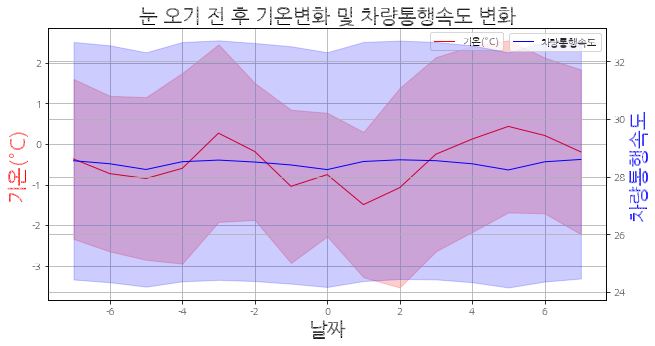

In [22]:
ax = sns.lineplot(x="day", y="기온(°C)", data=zero_df, color='r', ci='sd',label='기온(°C)')
ax2 = ax.twinx()
sns.lineplot(x="day", y="차량통행속도", data=zero_df, color='b', ci='sd',label='차량통행속도')
# ax.figure.legend()

ax.grid(True)
ax2.grid(True)

plt.title("눈 오기 전 후 기온변화 및 차량통행속도 변화", fontsize=20,color='black')

ax.set_xlabel('날짜', fontsize=20, color='black')

ax.set_ylabel("기온(°C)",fontsize=20,color='red')
ax2.set_ylabel("차량통행속도",fontsize=20,color='blue')

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 1

ax.legend(loc='lower left', bbox_to_anchor=(0.675,0.9))
ax2.legend()

fig = plt.gcf()
plt.show()
fig.savefig('graph_change_std.png')

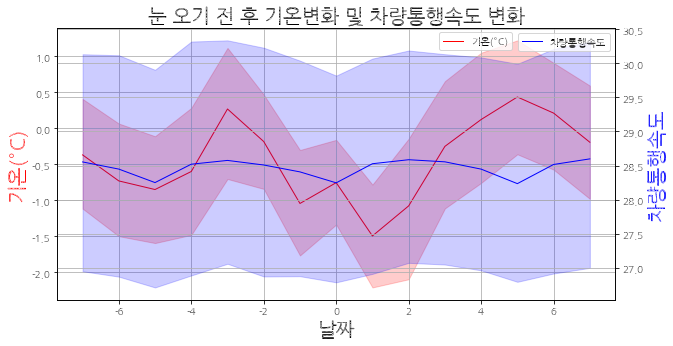

In [23]:
ax = sns.lineplot(x="day", y="기온(°C)", data=zero_df, color='r',label='기온(°C)')
ax2 = ax.twinx()
sns.lineplot(x="day", y="차량통행속도", data=zero_df, color='b', label='차량통행속도')
# ax.figure.legend()

ax.grid(True)
ax2.grid(True)

plt.title("눈 오기 전 후 기온변화 및 차량통행속도 변화", fontsize=20,color='black')

ax.set_xlabel('날짜', fontsize=20, color='black')

ax.set_ylabel("기온(°C)",fontsize=20,color='red')
ax2.set_ylabel("차량통행속도",fontsize=20,color='blue')

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 1

ax.legend(loc='lower left', bbox_to_anchor=(0.675,0.9))
ax2.legend()

fig = plt.gcf()
plt.show()

/home/jongsky/anaconda3/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing 'normal' to axis() is deprecated since 3.1; use 'auto' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


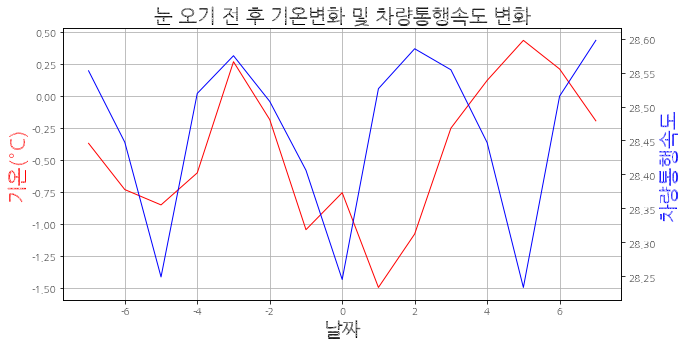

In [17]:
ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')

ax.plot(group_zero_df['day'].tolist(), group_zero_df['기온(°C)'].tolist(), color='r')
ax2.plot(group_zero_df['day'].tolist(), group_zero_df['차량통행속도'].tolist(), color='b')

ax.set_ylabel("기온(°C)",fontsize=20,color='red')
ax2.set_ylabel("차량통행속도",fontsize=20,color='blue')

ax.grid(True)

plt.title("눈 오기 전 후 기온변화 및 차량통행속도 변화", fontsize=20,color='black')

ax.set_xlabel('날짜', fontsize=20, color='black')

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 1

fig = plt.gcf()
plt.show()
fig.savefig('graph_change.png')

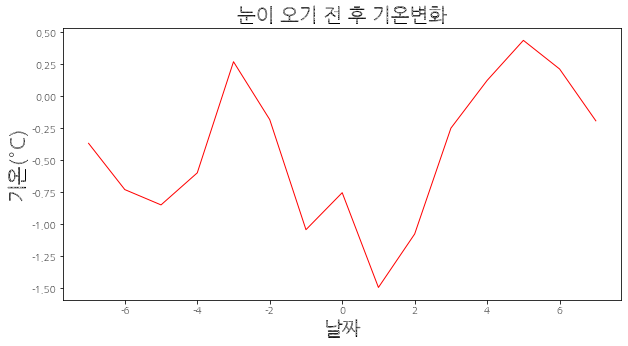

In [18]:
# plt.axis('normal')
plt.plot(group_zero_df['day'].tolist(), group_zero_df['기온(°C)'].tolist(), color='r')

plt.ylabel("기온(°C)",fontsize=20,color='black')

ax.grid(True)

plt.title("눈이 오기 전 후 기온변화", fontsize=20,color='black')

plt.xlabel('날짜', fontsize=20, color='black')

# plt.xticks(rotation=180)

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 1

fig = plt.gcf()
plt.show()
fig.savefig('graph_change_tem.png')

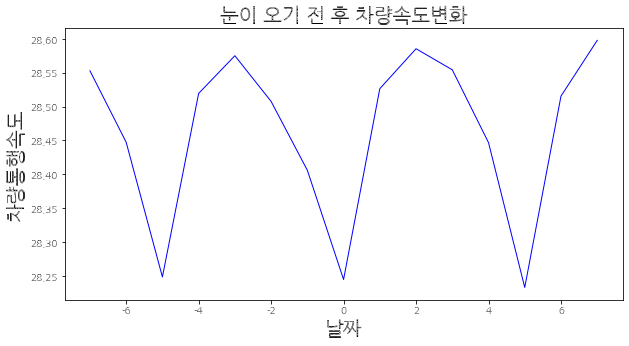

In [19]:
# plt.axis('normal')
plt.plot(group_zero_df['day'].tolist(), group_zero_df['차량통행속도'].tolist(), color='b')

plt.ylabel("차량통행속도",fontsize=20,color='black')

ax.grid(True)

plt.title("눈이 오기 전 후 차량속도변화", fontsize=20,color='black')

plt.xlabel('날짜', fontsize=20, color='black')

# plt.xticks(rotation=180)

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 1

fig = plt.gcf()
plt.show()
fig.savefig('graph_change_car.png')

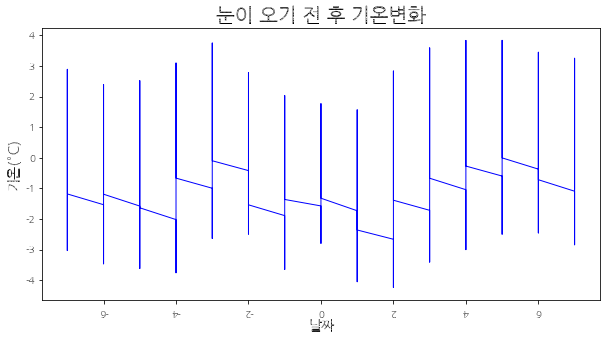

In [20]:
# plt.axis('normal')
plt.plot(zero_df['day'].tolist(), zero_df['기온(°C)'].tolist(), color='b')

plt.ylabel("기온(°C)",fontsize=14,color='black')

ax.grid(True)

plt.title("눈이 오기 전 후 기온변화", fontsize=20,color='black')

plt.xlabel('날짜', fontsize=14, color='black')

plt.xticks(rotation=180)

plt.show()

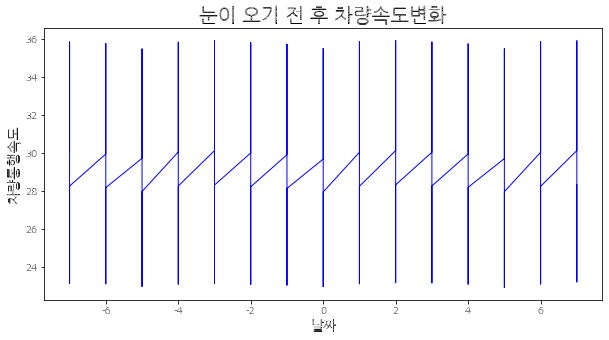

In [21]:
# plt.axis('normal')
plt.plot(zero_df['day'].tolist(), zero_df['차량통행속도'].tolist(), color='b')

plt.ylabel("차량통행속도",fontsize=14,color='black')

ax.grid(True)

plt.title("눈이 오기 전 후 차량속도변화", fontsize=20,color='black')

plt.xlabel('날짜', fontsize=14, color='black')

plt.show()